## Setup & Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import os
import random

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
print(DEVICE)

mps


## Load Dataset

In [3]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [5]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Utility Functions

In [6]:
def train_loop(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def val_loop(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def test_loop(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = correct / total
    return test_acc, np.array(all_labels), np.array(all_preds)

In [7]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True

        return False


In [8]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    early_stopper,
    num_epochs=30,
):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # ---- Train ----
        train_loss, train_acc = train_loop(model, train_loader, criterion, optimizer, device)

        # ---- Validate ----
        val_loss, val_acc = val_loop(model, val_loader, criterion, device)

        # ---- Log ----
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # ---- Early Stopping ----
        if early_stopper is not None:
            stop = early_stopper.early_stop(val_loss, model)
            if stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    # ---- Load Best Weights (if saved) ----
    if early_stopper is not None and early_stopper.model_path is not None:
        if os.path.exists(early_stopper.model_path):
            model.load_state_dict(torch.load(early_stopper.model_path, map_location=device))
            print(f"Loaded best model from {early_stopper.model_path}")

    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
    }
    return model, history


## Data Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


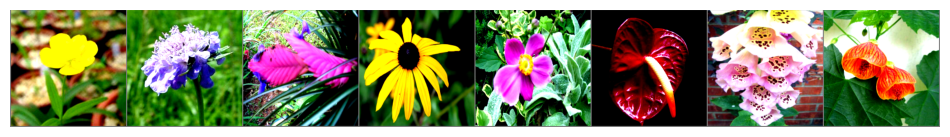

Labels: [47, 21, 92, 62, 61, 79, 93, 96]


In [9]:
# Class names are available in Flowers102
classes = train_dataset._labels  # Not human-readable, just numeric labels

# func to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize (optional)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 8 random images
plt.figure(figsize=(12, 6))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()

print("Labels:", labels[:8].tolist())

## 1. Pretrained Vision Transformer (ViT-B/16)

We chose to etart with a pretrained ViT instead of an untrained ViT as the training data of Flowers102 is small, with only 10 images per class. If we train a ViT from scratch using only 1020 images, the model might suffer from overfitting or not be meaningful, giving ugly or noisy results that are difficult to interpret. 

The ViT-B/16 model was pre-trained on ImageNet-21k (14 million images, 21,843 classes) and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes), with both pre-training and fine-tuning done at resolution 224x224.


> https://arxiv.org/pdf/2203.09795 (says that lr = 3e-4)

> TODO: Write proper remarks

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ViT_B_16_Weights

def get_vit_flowers(num_classes=102, device="cuda"):
    # Load ImageNet-pretrained ViT-B/16
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = models.vit_b_16(weights=weights)

    # Replace classification head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

    return model.to(device)


In [ ]:
print(DEVICE)

# ---HYPERPARAMETERS---
NUM_EPOCH = 20
LR = 3e-4
WEIGHT_DECAY = 0.05
PATIENCE = 5
MIN_DELTA = 0.0

model = get_vit_flowers(num_classes=102, device=DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA , model_path="best_vit.pt")

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device = DEVICE,
    early_stopper=early_stopper,
    num_epochs=NUM_EPOCH
)

mps

Epoch 1/20


Train Loss: 4.5889 | Train Acc: 0.0137
Val   Loss: 4.2314 | Val   Acc: 0.0461

Epoch 2/20


Train Loss: 3.9229 | Train Acc: 0.0686
Val   Loss: 3.5229 | Val   Acc: 0.1696

Epoch 3/20


Train Loss: 3.3401 | Train Acc: 0.1539
Val   Loss: 3.3806 | Val   Acc: 0.1539

Epoch 4/20


Train Loss: 2.9151 | Train Acc: 0.2412
Val   Loss: 3.0779 | Val   Acc: 0.2353

Epoch 5/20


Train Loss: 2.4684 | Train Acc: 0.3412
Val   Loss: 2.7621 | Val   Acc: 0.3127

Epoch 6/20


Train Loss: 2.0788 | Train Acc: 0.4422
Val   Loss: 2.6664 | Val   Acc: 0.3157

Epoch 7/20


Train Loss: 1.6866 | Train Acc: 0.5588
Val   Loss: 2.6144 | Val   Acc: 0.3324

Epoch 8/20


Train Loss: 1.2756 | Train Acc: 0.6657
Val   Loss: 2.5082 | Val   Acc: 0.3578

Epoch 9/20


Train Loss: 0.8676 | Train Acc: 0.7922
Val   Loss: 2.5219 | Val   Acc: 0.3863

Epoch 10/20


Train Loss: 0.5847 | Train Acc: 0.8676
Val   Loss: 2.4921 | Val   Acc: 0.3882

Epoch 11/20


Train Loss: 0.3970 | Train Acc: 0.9108
Val   Loss: 2.4934 | Val   Acc: 0.4108

Epoch 12/20


Train Loss: 0.2810 | Train Acc: 0.9382
Val   Loss: 2.5615 | Val   Acc: 0.3990

Epoch 13/20


Train Loss: 0.1634 | Train Acc: 0.9725
Val   Loss: 2.4741 | Val   Acc: 0.4382

Epoch 14/20


Train Loss: 0.0667 | Train Acc: 0.9882
Val   Loss: 2.5785 | Val   Acc: 0.4324

Epoch 15/20


Train Loss: 0.0626 | Train Acc: 0.9824
Val   Loss: 2.5423 | Val   Acc: 0.4353

Epoch 16/20


Train Loss: 0.0504 | Train Acc: 0.9892
Val   Loss: 2.5397 | Val   Acc: 0.4235

Epoch 17/20


Train Loss: 0.0296 | Train Acc: 0.9951
Val   Loss: 2.5435 | Val   Acc: 0.4588

Epoch 18/20


Train Loss: 0.0290 | Train Acc: 0.9951
Val   Loss: 2.5563 | Val   Acc: 0.4422
Early stopping triggered.
Early stopping triggered at epoch 18
Loaded best model from best_vit.pt


In [ ]:
test_acc, y_true, y_pred = test_loop(model, test_loader, DEVICE)
print("Test Accuracy:", test_acc)

Testing:   4%|▍         | 8/193 [00:50<09:29,  3.08s/it]  

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_losses"]) + 1)

plt.figure(figsize=(14, 6))

# ---- Left: Loss vs Epochs ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_losses"], label="Train Loss")
plt.plot(epochs, history["val_losses"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (ViT Transformer)")
plt.grid(True)
plt.legend()

# ---- Right: Accuracy vs Epochs ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_accs"], label="Train Accuracy")
plt.plot(epochs, history["val_accs"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (ViT Transformer)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameters Tuning of ViT model

In [ ]:
from itertools import product
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn
import torch

def build_vit(config, device):

    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)

    # Replace head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, 102)

    # Freeze / unfreeze
    for p in model.parameters():
        p.requires_grad = False

    if config["ft_strategy"] == "full":
        for p in model.parameters():
            p.requires_grad = True
    elif config["ft_strategy"] == "last_block":
        for p in model.encoder.layers[-1].parameters():
            p.requires_grad = True
        for p in model.heads.parameters():
            p.requires_grad = True
    elif config["ft_strategy"] == "head":
        for p in model.heads.parameters():
            p.requires_grad = True
    else:
        raise ValueError("Invalid fine-tuning strategy")

    optimizer = torch.optim.AdamW(
        (p for p in model.parameters() if p.requires_grad),
        lr=config["lr"],
        weight_decay=config["weight_decay"],
    )

    model = model.to(device)
    return model, optimizer


In [21]:
def find_optimal_vit_hyperparams(param_grid, train_loader, val_loader, device):
    best_val_acc = 0
    best_config = None
    results = []

    all_combinations = list(product(*param_grid.values()))
    keys = list(param_grid.keys())

    for combo in all_combinations:
        config = dict(zip(keys, combo))
        print(f"\nTraining with config: {config}")

        # Build model + optimizer
        model, optimizer = build_vit(config, device)
        criterion = nn.CrossEntropyLoss()
        early_stopper = EarlyStopper(patience=5, min_delta=0.0, model_path=None)

        # Train
        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            early_stopper=early_stopper,
            num_epochs=20,
        )

        # Get best val accuracy
        max_val_acc = max(history["val_accs"])
        results.append({**config, "best_val_acc": max_val_acc})
        print(f"Validation Accuracy: {max_val_acc:.4f}")

        if max_val_acc > best_val_acc:
            best_val_acc = max_val_acc
            best_config = config

    print("\n Best config found:")
    print(best_config)
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    return results, best_config


In [ ]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", DEVICE)

param_grid = {
    "lr": [0.0001, 0.0003, 0.001, 0.003],
    "ft_strategy": ["full", "last_block", "head"],
}

results, best_config = find_optimal_vit_hyperparams(param_grid, train_loader, val_loader, DEVICE)

Using device: mps

Training with config: {'lr': 0.0003, 'weight_decay': 0.05, 'ft_strategy': 'full'}

Epoch 1/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(74650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Training:   9%|▉         | 3/32 [14:22<2:16:28, 282.37s/it]

# PREVIOUS HP TUNING (DELETE)

> say that initial hp tuning showed that lr = 3e-4 not good, so we focused on hp tuning w fixing lr to be 12-4

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ViT_B_16_Weights

def build_vit(config, device):
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = models.vit_b_16(weights=weights)

    # Replace head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, 102)

    # Freeze / unfreeze according to strategy
    strategy = config["ft_strategy"]

    # First freeze everything
    for p in model.parameters():
        p.requires_grad = False

    if strategy == "full":
        for p in model.parameters():
            p.requires_grad = True

    elif strategy == "last_block":
        # last transformer block + head
        for p in model.encoder.layers[-1].parameters():
            p.requires_grad = True
        for p in model.heads.parameters():
            p.requires_grad = True

    elif strategy == "head":
        for p in model.heads.parameters():
            p.requires_grad = True

    else:
        raise ValueError(f"Unknown ft_strategy: {strategy}")

    model = model.to(device)

    # Optimizer over trainable params only
    optimizer = torch.optim.AdamW(
        (p for p in model.parameters() if p.requires_grad),
        lr=config["lr"],
        weight_decay=config["weight_decay"],
    )

    return model, optimizer


In [16]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", DEVICE)

configs = [
    {"name": "A_full_lr3e-4_wd0.05", "ft_strategy": "full",       "lr": 3e-4, "weight_decay": 0.05},
    {"name": "B_full_lr1e-4_wd0.05", "ft_strategy": "full",       "lr": 1e-4, "weight_decay": 0.05},
    {"name": "C_last_lr1e-4_wd0.01", "ft_strategy": "last_block", "lr": 1e-4, "weight_decay": 0.01},
    {"name": "D_head_lr1e-3_wd0.00", "ft_strategy": "head",       "lr": 1e-3, "weight_decay": 0.00},
]

results = []

for cfg in configs:
    print(f"\n=== Running config {cfg['name']} ===")

    model, optimizer = build_vit(cfg, DEVICE)
    criterion = nn.CrossEntropyLoss()
    early_stopper = EarlyStopper(
        patience=5,
        min_delta=0.0,
        model_path=f"best_{cfg['name']}.pth"
    )

    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        early_stopper=early_stopper,
        num_epochs=20,
    )

    test_acc, y_true, y_pred = test_loop(model, test_loader, DEVICE)
    print(f"Test Accuracy ({cfg['name']}): {test_acc:.4f}")

    results.append({
        "config": cfg["name"],
        "val_best": max(history["val_accs"]),
        "test_acc": test_acc,
    })

print("\nSummary:")
for r in results:
    print(r)


Using device: mps

=== Running config A_full_lr3e-4_wd0.05 ===

Epoch 1/20


Train Loss: 4.6589 | Train Acc: 0.0147
Val   Loss: 4.3505 | Val   Acc: 0.0333

Epoch 2/20


Train Loss: 4.0367 | Train Acc: 0.0637
Val   Loss: 3.7103 | Val   Acc: 0.1098

Epoch 3/20


Train Loss: 3.4249 | Train Acc: 0.1539
Val   Loss: 3.2239 | Val   Acc: 0.2010

Epoch 4/20


Train Loss: 2.9395 | Train Acc: 0.2451
Val   Loss: 3.0780 | Val   Acc: 0.2314

Epoch 5/20


Train Loss: 2.5589 | Train Acc: 0.3206
Val   Loss: 2.9060 | Val   Acc: 0.2804

Epoch 6/20


Train Loss: 2.1830 | Train Acc: 0.3941
Val   Loss: 2.7617 | Val   Acc: 0.3010

Epoch 7/20


Train Loss: 1.7182 | Train Acc: 0.5392
Val   Loss: 2.6112 | Val   Acc: 0.3431

Epoch 8/20


Train Loss: 1.3079 | Train Acc: 0.6549
Val   Loss: 2.5368 | Val   Acc: 0.3480

Epoch 9/20


Train Loss: 0.9316 | Train Acc: 0.7725
Val   Loss: 2.5702 | Val   Acc: 0.3775

Epoch 10/20


Train Loss: 0.6081 | Train Acc: 0.8686
Val   Loss: 2.6494 | Val   Acc: 0.3539

Epoch 11/20


Train Loss: 0.3720 | Train Acc: 0.9363
Val   Loss: 2.5453 | Val   Acc: 0.3941

Epoch 12/20


Train Loss: 0.2170 | Train Acc: 0.9539
Val   Loss: 2.5956 | Val   Acc: 0.4059

Epoch 13/20


Train Loss: 0.1648 | Train Acc: 0.9627
Val   Loss: 2.5587 | Val   Acc: 0.4108
Early stopping triggered.
Early stopping triggered at epoch 13
Loaded best model from best_A_full_lr3e-4_wd0.05.pth


Test Accuracy (A_full_lr3e-4_wd0.05): 0.3516

=== Running config B_full_lr1e-4_wd0.05 ===

Epoch 1/20


Train Loss: 4.0598 | Train Acc: 0.1667
Val   Loss: 2.7661 | Val   Acc: 0.5775

Epoch 2/20


Train Loss: 1.7204 | Train Acc: 0.8343
Val   Loss: 1.3935 | Val   Acc: 0.8471

Epoch 3/20


Train Loss: 0.4746 | Train Acc: 0.9863
Val   Loss: 0.8640 | Val   Acc: 0.9049

Epoch 4/20


Train Loss: 0.1207 | Train Acc: 1.0000
Val   Loss: 0.6581 | Val   Acc: 0.9118

Epoch 5/20


Train Loss: 0.0499 | Train Acc: 1.0000
Val   Loss: 0.5690 | Val   Acc: 0.9225

Epoch 6/20


Train Loss: 0.0314 | Train Acc: 1.0000
Val   Loss: 0.5366 | Val   Acc: 0.9176

Epoch 7/20


Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(62315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(62316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(62317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(62318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0235 | Train Acc: 1.0000
Val   Loss: 0.5161 | Val   Acc: 0.9275

Epoch 8/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(62570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(62571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(62572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(62573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]        Python(63469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0189 | Train Acc: 1.0000
Val   Loss: 0.5034 | Val   Acc: 0.9225

Epoch 9/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(63622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(63819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63822) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0157 | Train Acc: 1.0000
Val   Loss: 0.4891 | Val   Acc: 0.9255

Epoch 10/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(63888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(64021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0133 | Train Acc: 1.0000
Val   Loss: 0.4799 | Val   Acc: 0.9265

Epoch 11/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(64105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64106) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(64277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0115 | Train Acc: 1.0000
Val   Loss: 0.4699 | Val   Acc: 0.9284

Epoch 12/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(64308) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(64399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0101 | Train Acc: 1.0000
Val   Loss: 0.4619 | Val   Acc: 0.9314

Epoch 13/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(64429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(64527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0090 | Train Acc: 1.0000
Val   Loss: 0.4565 | Val   Acc: 0.9304

Epoch 14/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(64552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(64794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0080 | Train Acc: 1.0000
Val   Loss: 0.4561 | Val   Acc: 0.9284

Epoch 15/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(64833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(64941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0072 | Train Acc: 1.0000
Val   Loss: 0.4468 | Val   Acc: 0.9265

Epoch 16/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(64973) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64975) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64976) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0066 | Train Acc: 1.0000
Val   Loss: 0.4401 | Val   Acc: 0.9284

Epoch 17/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65148) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65149) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0060 | Train Acc: 1.0000
Val   Loss: 0.4386 | Val   Acc: 0.9284

Epoch 18/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65308) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0055 | Train Acc: 1.0000
Val   Loss: 0.4341 | Val   Acc: 0.9294

Epoch 19/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0051 | Train Acc: 1.0000
Val   Loss: 0.4303 | Val   Acc: 0.9314

Epoch 20/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0048 | Train Acc: 1.0000
Val   Loss: 0.4294 | Val   Acc: 0.9294
Loaded best model from best_B_full_lr1e-4_wd0.05.pth


Testing:   0%|          | 0/193 [00:00<?, ?it/s]Python(65652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test Accuracy (B_full_lr1e-4_wd0.05): 0.9027

=== Running config C_last_lr1e-4_wd0.01 ===

Epoch 1/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 4.4933 | Train Acc: 0.0598
Val   Loss: 4.0764 | Val   Acc: 0.2118

Epoch 2/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 3.4227 | Train Acc: 0.4686
Val   Loss: 3.0445 | Val   Acc: 0.5157

Epoch 3/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 2.3108 | Train Acc: 0.7627
Val   Loss: 2.3341 | Val   Acc: 0.6794

Epoch 4/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 1.5327 | Train Acc: 0.9078
Val   Loss: 1.8244 | Val   Acc: 0.7608

Epoch 5/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(65938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(65968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(65971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 1.0170 | Train Acc: 0.9539
Val   Loss: 1.5079 | Val   Acc: 0.8118

Epoch 6/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.6813 | Train Acc: 0.9863
Val   Loss: 1.2921 | Val   Acc: 0.8471

Epoch 7/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66111) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66114) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.4639 | Train Acc: 0.9941
Val   Loss: 1.1462 | Val   Acc: 0.8569

Epoch 8/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.3274 | Train Acc: 0.9951
Val   Loss: 1.0431 | Val   Acc: 0.8520

Epoch 9/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.2347 | Train Acc: 0.9990
Val   Loss: 0.9623 | Val   Acc: 0.8676

Epoch 10/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66302) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1744 | Train Acc: 0.9990
Val   Loss: 0.9072 | Val   Acc: 0.8716

Epoch 11/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66557) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1375 | Train Acc: 0.9990
Val   Loss: 0.8643 | Val   Acc: 0.8725

Epoch 12/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1108 | Train Acc: 1.0000
Val   Loss: 0.8286 | Val   Acc: 0.8794

Epoch 13/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0911 | Train Acc: 1.0000
Val   Loss: 0.8030 | Val   Acc: 0.8784

Epoch 14/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0771 | Train Acc: 1.0000
Val   Loss: 0.7775 | Val   Acc: 0.8765

Epoch 15/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(66907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(66928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0666 | Train Acc: 1.0000
Val   Loss: 0.7569 | Val   Acc: 0.8784

Epoch 16/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]         Python(67304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0576 | Train Acc: 1.0000
Val   Loss: 0.7381 | Val   Acc: 0.8784

Epoch 17/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(67366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0508 | Train Acc: 1.0000
Val   Loss: 0.7251 | Val   Acc: 0.8814

Epoch 18/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(67406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0457 | Train Acc: 1.0000
Val   Loss: 0.7124 | Val   Acc: 0.8784

Epoch 19/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(67456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0410 | Train Acc: 1.0000
Val   Loss: 0.7020 | Val   Acc: 0.8784

Epoch 20/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(67512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0370 | Train Acc: 1.0000
Val   Loss: 0.6903 | Val   Acc: 0.8843
Loaded best model from best_C_last_lr1e-4_wd0.01.pth


Testing:   0%|          | 0/193 [00:00<?, ?it/s]Python(67580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test Accuracy (C_last_lr1e-4_wd0.01): 0.8678

=== Running config D_head_lr1e-3_wd0.00 ===

Epoch 1/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(67968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 4.1647 | Train Acc: 0.1549
Val   Loss: 3.1941 | Val   Acc: 0.5049

Epoch 2/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(67980) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67983) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(67995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 2.4219 | Train Acc: 0.7059
Val   Loss: 2.2198 | Val   Acc: 0.7049

Epoch 3/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68196) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 1.4879 | Train Acc: 0.8627
Val   Loss: 1.6881 | Val   Acc: 0.7637

Epoch 4/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.9665 | Train Acc: 0.9382
Val   Loss: 1.4022 | Val   Acc: 0.7882

Epoch 5/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.6771 | Train Acc: 0.9735
Val   Loss: 1.2184 | Val   Acc: 0.8098

Epoch 6/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.4979 | Train Acc: 0.9843
Val   Loss: 1.0973 | Val   Acc: 0.8216

Epoch 7/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.3799 | Train Acc: 0.9922
Val   Loss: 1.0118 | Val   Acc: 0.8324

Epoch 8/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.3000 | Train Acc: 0.9971
Val   Loss: 0.9464 | Val   Acc: 0.8392

Epoch 9/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68445) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.2408 | Train Acc: 0.9961
Val   Loss: 0.8948 | Val   Acc: 0.8402

Epoch 10/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68504) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68505) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1961 | Train Acc: 0.9980
Val   Loss: 0.8525 | Val   Acc: 0.8520

Epoch 11/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68536) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1658 | Train Acc: 0.9990
Val   Loss: 0.8219 | Val   Acc: 0.8461

Epoch 12/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1399 | Train Acc: 1.0000
Val   Loss: 0.7939 | Val   Acc: 0.8569

Epoch 13/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1214 | Train Acc: 1.0000
Val   Loss: 0.7693 | Val   Acc: 0.8569

Epoch 14/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68659) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68660) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1056 | Train Acc: 1.0000
Val   Loss: 0.7505 | Val   Acc: 0.8578

Epoch 15/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0931 | Train Acc: 1.0000
Val   Loss: 0.7311 | Val   Acc: 0.8618

Epoch 16/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0832 | Train Acc: 1.0000
Val   Loss: 0.7165 | Val   Acc: 0.8598

Epoch 17/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0746 | Train Acc: 1.0000
Val   Loss: 0.7034 | Val   Acc: 0.8618

Epoch 18/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0674 | Train Acc: 1.0000
Val   Loss: 0.6909 | Val   Acc: 0.8618

Epoch 19/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0613 | Train Acc: 1.0000
Val   Loss: 0.6799 | Val   Acc: 0.8627

Epoch 20/20


Training:   0%|          | 0/32 [00:00<?, ?it/s]Python(68931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Validating:   0%|          | 0/32 [00:00<?, ?it/s]       Python(68998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0561 | Train Acc: 1.0000
Val   Loss: 0.6690 | Val   Acc: 0.8627
Loaded best model from best_D_head_lr1e-3_wd0.00.pth


Testing:   0%|          | 0/193 [00:00<?, ?it/s]Python(69192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
                                                          

Test Accuracy (D_head_lr1e-3_wd0.00): 0.8369

Summary:
{'config': 'A_full_lr3e-4_wd0.05', 'val_best': 0.4107843137254902, 'test_acc': 0.3516018864856074}
{'config': 'B_full_lr1e-4_wd0.05', 'val_best': 0.9313725490196079, 'test_acc': 0.9027484143763214}
{'config': 'C_last_lr1e-4_wd0.01', 'val_best': 0.884313725490196, 'test_acc': 0.8677833794112864}
{'config': 'D_head_lr1e-3_wd0.00', 'val_best': 0.8627450980392157, 'test_acc': 0.8368840461863718}


In [13]:
import torch

print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

MPS available: True
MPS built: True


In [8]:
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # x: [B, 3, 224, 224]
        x = self.proj(x)                  # [B, embed_dim, H/patch, W/patch]
        x = x.flatten(2)                  # [B, embed_dim, num_patches]
        x = x.transpose(1, 2)             # [B, num_patches, embed_dim]
        return x


class TransformerEncoderBlock(nn.Module):
    """A single transformer encoder block."""
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [sequence_length, batch_size, embed_dim]
        attn_out, _ = self.attn(x, x, x)
        x = x + self.dropout(attn_out)
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """A simplified Vision Transformer for image classification."""
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 num_classes=102, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embed.num_patches

        # CLS token + positional encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        # Transformer encoder stack
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)          # [B, 1+num_patches, embed_dim]
        x = x + self.pos_embed                         # add position encoding
        x = self.pos_drop(x)

        # Transformer expects sequence-first: [seq_len, batch, embed_dim]
        x = x.transpose(0, 1)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x.transpose(0, 1))               # back to [B, seq, embed_dim]

        cls_out = x[:, 0]                              # CLS token output
        logits = self.head(cls_out)                    # [B, num_classes]
        return logits


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(
    img_size=224,
    patch_size=16,
    num_classes=102,   # Flowers102 dataset
    embed_dim=384,     # smaller ViT for faster training
    depth=6,
    num_heads=6
).to(device)

print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

# Test with dummy data
x = torch.randn(4, 3, 224, 224).to(device)
out = model(x)
print("Output shape:", out.shape)

11.05815 M parameters
Output shape: torch.Size([4, 102])


## 1. Base Transformer Model (without Pre-Train Weights)

In [14]:
class SimpleTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=102,
        embed_dim=256,
        depth=4,
        num_heads=4,
        mlp_ratio=4.0,
    ):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.img_size = img_size
        self.patch_size = patch_size

        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size

        # Patch → embedding
        self.patch_embed = nn.Linear(patch_dim, embed_dim)

        # [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embedding for [CLS] + all patches
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embed_dim))

        # Simple Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Expected {self.img_size}x{self.img_size}, got {H}x{W}"

        # Split into patches: (B, C, H, W) -> (B, num_patches, patch_dim)
        patches = x.unfold(2, self.patch_size, self.patch_size) \
                   .unfold(3, self.patch_size, self.patch_size)
        # Now shape: (B, C, H_p, W_p, p_h, p_w)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 1, 3, 4)  # (B, num_patches, C, p_h, p_w)
        patches = patches.reshape(B, self.num_patches, -1)  # (B, num_patches, patch_dim)

        # Linear projection
        x = self.patch_embed(patches)  # (B, num_patches, embed_dim)

        # Add [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed

        # Transformer encoder
        x = self.transformer(x)

        # Take [CLS] token
        cls_out = x[:, 0]  # (B, embed_dim)

        # Normalize + classify
        cls_out = self.norm(cls_out)
        logits = self.head(cls_out)  # (B, num_classes)

        return logits

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

model = SimpleTransformer(num_classes=102).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

early_stopper = EarlyStopper(
    patience=5,
    min_delta=0.001,
    verbose=True,
    model_path="best_simpletransformer.pth"
)

Using device: mps


In [26]:
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    early_stopper=early_stopper,
    num_epochs=20
)


Epoch 1/20


Train Loss: 1.1161 | Train Acc: 0.7343
Val   Loss: 2.9954 | Val   Acc: 0.3029

Epoch 2/20


Train Loss: 0.9912 | Train Acc: 0.7706
Val   Loss: 3.0993 | Val   Acc: 0.2951
Early stopping triggered.
Early stopping triggered at epoch 2
Loaded best model from best_simpletransformer.pth
